In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.models import SVGP
from gpflow.utilities import read_values, multiple_assign, set_trainable

import invgp
from invgp.models.sample_SVGP import sample_SVGP
from invgp_experiments import utils
from invgp.inducing_variables.invariant_convolution_domain import StochasticConvolvedInducingPoints

In [2]:
np.random.seed(0)

In [3]:
# generate 200 datapoints
X = np.random.uniform(-3, 3, 400)[:, None]
X = np.reshape(X, [200, 2]) # 2-dimensional input
Y = np.sqrt(X[:, 0]**2 + X[:, 1]**2)[..., None] + np.random.randn(len(X), 1) * 0.1
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

__Initialize models__

In [4]:
inducing_variables_creator = lambda: StochasticConvolvedInducingPoints(X.copy())
# inducing_variables_creator = lambda: X.copy()
kernel_creator = lambda: invgp.kernels.StochasticInvariant(
    basekern=gpflow.kernels.SquaredExponential(),
    orbit=invgp.kernels.orbits.SwitchXY()
)

SVGP_model, sample_SVGP_model, matheron_sample_SVGP_model = [
    m(
        kernel_creator(),
        gpflow.likelihoods.Gaussian(),
        inducing_variable=inducing_variables_creator(),
        num_data=len(X),
        **kw,
    )
    for m, kw in [(SVGP, {}), (sample_SVGP, {"matheron_sampler": False}), (sample_SVGP, {"matheron_sampler": True})]
]

__Define and run the optimiziation loop for SVGP model__

In [5]:
train_iter = iter(train_dataset.repeat())
training_loss = SVGP_model.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
set_trainable(SVGP_model.inducing_variable, False)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, SVGP_model.trainable_variables)
elbo_hist = []
for step in range(2000):
    optimization_step()
    if step % 10 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

stochastic_inv_conditional
sub conditional
Step: 0, Mini batch elbo: -824.9394891257768
Step: 10, Mini batch elbo: -696.6004579641348
Step: 20, Mini batch elbo: -608.7858618062231
Step: 30, Mini batch elbo: -539.1431030629968
Step: 40, Mini batch elbo: -482.2819587912027
Step: 50, Mini batch elbo: -435.592197223041
Step: 60, Mini batch elbo: -397.2143113161678
Step: 70, Mini batch elbo: -365.7958296575103
Step: 80, Mini batch elbo: -340.27586865205484
Step: 90, Mini batch elbo: -319.60708035893697
Step: 100, Mini batch elbo: -302.7813663619299
Step: 110, Mini batch elbo: -289.0607986892544
Step: 120, Mini batch elbo: -277.94238854249284
Step: 130, Mini batch elbo: -268.97405301534695
Step: 140, Mini batch elbo: -261.6636305215038
Step: 150, Mini batch elbo: -255.52547739475045
Step: 160, Mini batch elbo: -250.1521669179421
Step: 170, Mini batch elbo: -245.24737497359126
Step: 180, Mini batch elbo: -240.62015533071644
Step: 190, Mini batch elbo: -236.1575569263382
Step: 200, Mini batch 

Step: 1730, Mini batch elbo: 122.21242950189864
Step: 1740, Mini batch elbo: 122.15725356015972
Step: 1750, Mini batch elbo: 122.28501638289842
Step: 1760, Mini batch elbo: 122.2493985620467
Step: 1770, Mini batch elbo: 122.19247057028397
Step: 1780, Mini batch elbo: 122.36894043550039
Step: 1790, Mini batch elbo: 122.465903921256
Step: 1800, Mini batch elbo: 122.49594929154856
Step: 1810, Mini batch elbo: 122.55203946533857
Step: 1820, Mini batch elbo: 122.51490422358529
Step: 1830, Mini batch elbo: 121.62571874038797
Step: 1840, Mini batch elbo: 122.46933081435077
Step: 1850, Mini batch elbo: 122.6390580941433
Step: 1860, Mini batch elbo: 122.70931958821153
Step: 1870, Mini batch elbo: 122.74625957907111
Step: 1880, Mini batch elbo: 122.75384972368403
Step: 1890, Mini batch elbo: 122.79291535843893
Step: 1900, Mini batch elbo: 122.80947328094378
Step: 1910, Mini batch elbo: 122.85397388242151
Step: 1920, Mini batch elbo: 122.67752240057456
Step: 1930, Mini batch elbo: 122.72289905918

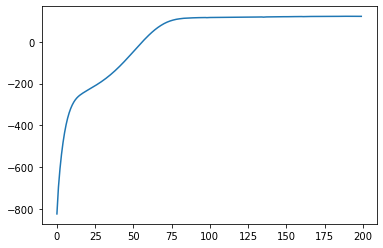

In [6]:
plt.plot(elbo_hist)

__Initialize sample_SVGP models with fitted parameters from SVGP__

In [7]:
trained_params = read_values(SVGP_model)
multiple_assign(sample_SVGP_model, trained_params)
multiple_assign(matheron_sample_SVGP_model, trained_params)

stochastic_inv_conditional
sub conditional
Running invariant kernel sample_conditional.


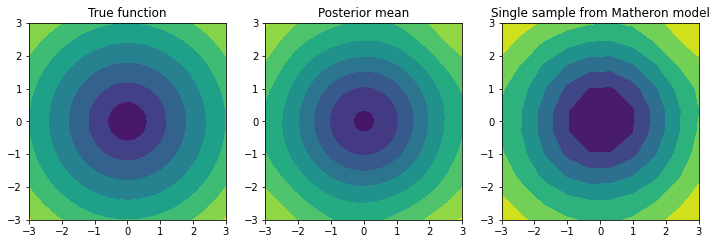

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 15))
x1list = np.linspace(-3.0, 3.0, 100)
x2list = np.linspace(-3.0, 3.0, 100)
X1, X2 = np.meshgrid(x1list, x2list)
ax[0].set_title('True function')
ax[0].set_aspect('equal', 'box')

# plot the true data generating process
true_Z = np.sqrt(X1**2 + X2**2)
cp = ax[0].contourf(X1, X2, true_Z)

# plot the SVGP mean prediction
positions = np.vstack([X1.ravel(), X2.ravel()])
mean, var = SVGP_model.predict_f(positions.T)
cp = ax[1].contourf(X1, X2, np.reshape(mean.numpy().T, X1.shape))
ax[1].set_title('Posterior mean')
ax[1].set_aspect('equal', 'box')

# plot a matheron sample_SVGP sample
x1list_coarse = np.linspace(-3.0, 3.0, 10)
x2list_coarse = np.linspace(-3.0, 3.0, 10)
X1_coarse, X2_coarse = np.meshgrid(x1list_coarse, x2list_coarse)
positions_coarse = np.vstack([X1_coarse.ravel(), X2_coarse.ravel()])
samples = matheron_sample_SVGP_model.predict_f_samples(positions_coarse.T, num_samples=1)
cp = ax[2].contourf(X1_coarse, X2_coarse, np.reshape(samples.numpy().T, X1_coarse.shape))
ax[2].set_title('Single sample from Matheron model')
ax[2].set_aspect('equal', 'box')

plt.show()

In [9]:
#compare elbos
SVGP_model_elbo = SVGP_model.elbo((X, Y))
sample_SVGP_model_elbos = [sample_SVGP_model.elbo((X, Y)).numpy() for _ in range(10)]
expected_sample_elbo = np.mean(sample_SVGP_model_elbos)
var_sample_elbo = np.var(sample_SVGP_model_elbos)
np.testing.assert_allclose(SVGP_model_elbo, expected_sample_elbo, rtol=0.05, atol=0.0) 

matheron_sample_SVGP_model_elbos = [matheron_sample_SVGP_model.elbo((X, Y)).numpy() for _ in range(10)]
expected_matheron_sample_elbo = np.mean(matheron_sample_SVGP_model_elbos)
var_matheron_sample_elbo = np.var(matheron_sample_SVGP_model_elbos)

stochastic_inv_conditional
sub conditional
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.
Running invariant kernel sample_conditional.


In [10]:
print('SVGP model elbo is:', SVGP_model_elbo.numpy())
print('Expectation and variance of the sample ELBO estimator:', expected_sample_elbo, var_sample_elbo)
print('Expectation and variance of the Matheron sample ELBO estimator:', expected_matheron_sample_elbo, var_matheron_sample_elbo)

SVGP model elbo is: 122.99228799518755
Expectation and variance of the sample ELBO estimator: 123.51001577926195 2.6776911940605026
Expectation and variance of the Matheron sample ELBO estimator: 122.32897677417748 2.6092922920179538
